In [13]:
# === Config ===
from pathlib import Path
import re, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (필수) 이번 튜닝 런의 OUT_ROOT (잡 스크립트에서 --out_root 로 준 경로)
# 예: "/caefs/user/mmingyeong/2508_slchallence/optuna_runs/20250905_153012"
#OUT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence/2508_slchallence/res/optuna_runs/20250905_221042").expanduser()

# (선택) 여러 런이 한 디렉터리에 있다면, 가장 최근(수정시각 최신) 런을 자동 선택
PARENT = Path("/caefs/user/mmingyeong/2508_slchallence/res/optuna_runs/20250905_221042")
OUT_ROOT = max(PARENT.iterdir(), key=lambda p: p.stat().st_mtime)

print("OUT_ROOT:", OUT_ROOT)
assert OUT_ROOT.exists(), "OUT_ROOT 경로가 존재하지 않습니다."


OUT_ROOT: /caefs/user/mmingyeong/2508_slchallence/res/optuna_runs/20250905_221042/trial_023_atto_bs128


In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import re
import math

root = Path(OUT_ROOT)

# ---------- helpers ----------
def _safe_isna(x):
    return x is None or (isinstance(x, float) and (math.isnan(x)))

def _coalesce(x, default):
    return default if _safe_isna(x) else x

def _read_csv_metrics(csv_path: Path):
    """Return dict with best/last val_auc, best epoch, lr (from csv), epochs (max epoch)."""
    out = dict(val_auc_best=np.nan, val_auc_best_epoch=np.nan,
               val_auc_last=np.nan, lr=np.nan, epochs=np.nan)
    if not csv_path.exists():
        return out
    df = pd.read_csv(csv_path)
    if "val_auc" in df.columns and "epoch" in df.columns and len(df):
        i = df["val_auc"].idxmax()
        out["val_auc_best"] = float(df["val_auc"].iloc[i])
        out["val_auc_best_epoch"] = int(df["epoch"].iloc[i])
        out["val_auc_last"] = float(df["val_auc"].iloc[-1])
    if "lr" in df.columns and len(df):
        out["lr"] = float(df["lr"].dropna().iloc[-1])
    if "epoch" in df.columns and len(df):
        out["epochs"] = int(df["epoch"].max())
    return out

def _read_results_json(res_path: Path):
    """
    Returns a flattened dict with test metrics and any config hyperparams if present.
    Handles either:
      {best_val_loss, test_loss, test_acc, test_auc, config:{...}}
    or   {"root":{best_val_loss,...}, "config":{...}}
    """
    out = {}
    if not res_path.exists():
        return out
    with open(res_path, "r") as f:
        data = json.load(f)

    # Flatten possible structures
    root_like = data.get("root", data) if isinstance(data, dict) else {}
    config_like = data.get("config", root_like.get("config", {})) if isinstance(data, dict) else {}

    # Pull known fields (use .get to be safe)
    out["test_auc"] = root_like.get("test_auc")
    out["test_acc"] = root_like.get("test_acc")
    # Hyperparams that might be inside config
    for k in ["model_size", "model_name", "weight_decay", "epochs", "patience", "batch_size", "lr"]:
        if k in config_like:
            out[k] = config_like[k]
    return out

def _parse_from_dirname_fallback(d: Path):
    """
    Try _parse_from_dirname (user's func). If missing, parse 'trial_###_<arch>_bs<batch>'.
    """
    try:
        return _parse_from_dirname(d)
    except Exception:
        pass
    m = re.match(r"^trial_(\d+)_([A-Za-z0-9\-]+)_bs(\d+)$", d.name)
    if m:
        return int(m.group(1)), m.group(2), int(m.group(3))
    return None, None, None

# ---------- discover trials ----------
if (root / "training_log.csv").exists():   # single-trial root
    trial_dirs = [root]
else:                                      # multi-trial root (timestamp dir)
    trial_dirs = sorted([p for p in root.glob("trial_*") if p.is_dir()])

rows = []
for d in trial_dirs:
    trial_no, arch_from_dir, batch = _parse_from_dirname_fallback(d)

    csv_path = d / "training_log.csv"
    res_path = d / "results.json"
    best_pt  = d / "best.pt"

    csvm = _read_csv_metrics(csv_path)
    res  = _read_results_json(res_path)

    # prefer lr from CSV; fall back to config if provided
    lr = _coalesce(csvm["lr"], res.get("lr"))
    epochs = _coalesce(csvm["epochs"], res.get("epochs"))
    weight_decay = res.get("weight_decay")
    patience = res.get("patience")

    rows.append({
        "trial": trial_no,
        "dir": str(d),
        "arch_dir": arch_from_dir,
        "arch_json": res.get("model_size") or res.get("model_name"),
        "batch": batch or res.get("batch_size"),
        "lr": lr,
        "weight_decay": weight_decay,
        "epochs": epochs,
        "patience": patience,
        "val_auc_best": csvm["val_auc_best"],
        "val_auc_best_epoch": csvm["val_auc_best_epoch"],
        "val_auc_last": csvm["val_auc_last"],
        "test_auc": res.get("test_auc", np.nan),
        "test_acc": res.get("test_acc", np.nan),
        "has_ckpt": best_pt.exists(),
    })

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError(f"No trials found under: {root}")

df = df.sort_values(["val_auc_best", "test_auc"], ascending=[False, False]).reset_index(drop=True)
print(f"Collected {len(df)} trial(s) from: {root}")
display(df.head(10))

# ---------- pretty print + reproduce template ----------
if len(df):
    top = df.iloc[0].to_dict()
    print("=== Best Trial (by val_auc_best) ===")
    for k in ["trial","arch_dir","batch","lr","weight_decay","epochs","patience",
              "val_auc_best","val_auc_best_epoch","test_auc","test_acc","dir"]:
        print(f"{k:>18}: {top.get(k)}")

    # coalesce for formatting
    lr           = float(_coalesce(top.get("lr"), 1e-3))
    weight_decay = float(_coalesce(top.get("weight_decay"), 0.0))
    epochs       = int(_coalesce(top.get("epochs"), 20))
    patience     = int(_coalesce(top.get("patience"), 5))
    batch        = int(_coalesce(top.get("batch"), 64))
    arch         = top.get("arch_dir") or _coalesce(top.get("arch_json"), "nano")

    REPRO = f"""
python -u /caefs/user/mmingyeong/2508_slchallence/src/train.py \\
  --slsim_lenses      /caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses \\
  --slsim_nonlenses   /caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses \\
  --hsc_lenses        /caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses \\
  --hsc_nonlenses     /caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses \\
  --model_size        {arch} \\
  --batch_size        {batch} \\
  --lr                {lr:.6g} \\
  --weight_decay      {weight_decay:.6g} \\
  --epochs            {epochs} \\
  --patience          {patience} \\
  --no_augment \\
  --apply_normalization \\
  --smoothing_mode    gaussian --gaussian_sigma 1.0 \\
  --save_dir          "{top['dir']}_retrain_full"
""".strip()
    print("\n--- Reproduce (template) ---\n" + REPRO)


Collected 1 trial(s) from: /caefs/user/mmingyeong/2508_slchallence/res/optuna_runs/20250905_221042/trial_023_atto_bs128


,trial,dir,arch_dir,arch_json,batch,lr,weight_decay,epochs,patience,val_auc_best,val_auc_best_epoch,val_auc_last,test_auc,test_acc,has_ckpt
0,23,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000349,None,15,None,0.942626,10,0.93088,0.943692,0.872108,True


=== Best Trial (by val_auc_best) ===
             trial: 23
          arch_dir: atto
             batch: 128
                lr: 0.0003485881
      weight_decay: None
            epochs: 15
          patience: None
      val_auc_best: 0.942626
val_auc_best_epoch: 10
          test_auc: 0.9436917540655013
          test_acc: 0.8721075192832047
               dir: /caefs/user/mmingyeong/2508_slchallence/res/optuna_runs/20250905_221042/trial_023_atto_bs128

--- Reproduce (template) ---
python -u /caefs/user/mmingyeong/2508_slchallence/src/train.py \
  --slsim_lenses      /caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses \
  --slsim_nonlenses   /caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses \
  --hsc_lenses        /caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses \
  --hsc_nonlenses     /caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses \
  --model_size        atto \
  --batch_size        128 \
  --lr                0.000348588 \
  

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import json, re, math

# ---- configure ----
ROOT = Path(OUT_ROOT)  # can be timestamp dir or a single trial dir
TRIAL_MIN, TRIAL_MAX = 0, 23

# ---- helpers ----
def _safe_isna(x):
    return x is None or (isinstance(x, float) and (math.isnan(x)))

def _coalesce(x, default):
    return default if _safe_isna(x) else x

def _read_csv_metrics(csv_path: Path):
    o = dict(val_auc_best=np.nan, val_auc_best_epoch=np.nan,
             val_auc_last=np.nan, lr=np.nan, epochs=np.nan)
    if not csv_path.exists():
        return o
    df = pd.read_csv(csv_path)
    if len(df):
        if "val_auc" in df and "epoch" in df:
            i = df["val_auc"].idxmax()
            o["val_auc_best"]       = float(df["val_auc"].iloc[i])
            o["val_auc_best_epoch"] = int(df["epoch"].iloc[i])
            o["val_auc_last"]       = float(df["val_auc"].iloc[-1])
        if "lr" in df:
            o["lr"] = float(df["lr"].dropna().iloc[-1])
        if "epoch" in df:
            o["epochs"] = int(df["epoch"].max())
    return o

def _read_results_json(res_path: Path):
    out = {}
    if not res_path.exists():
        return out
    with open(res_path, "r") as f:
        data = json.load(f)
    root_like   = data.get("root", data) if isinstance(data, dict) else {}
    config_like = data.get("config", root_like.get("config", {})) if isinstance(data, dict) else {}
    out["test_auc"] = root_like.get("test_auc")
    out["test_acc"] = root_like.get("test_acc")
    for k in ["model_size", "model_name", "weight_decay", "epochs", "patience", "batch_size", "lr"]:
        if k in config_like:
            out[k] = config_like[k]
    return out

def _parse_trial_tuple(d: Path):
    """Parse 'trial_###_<arch>_bs<batch>' -> (int trial, str arch, int batch)."""
    m = re.match(r"^trial_(\d+)_([A-Za-z0-9\-]+)_bs(\d+)$", d.name)
    if m:
        return int(m.group(1)), m.group(2), int(m.group(3))
    # fallback: accept just trial_###
    m2 = re.match(r"^trial_(\d+)$", d.name)
    if m2:
        return int(m2.group(1)), None, None
    return None, None, None

# ---- locate timestamp root & trial directories ----
timestamp_root = ROOT if not (ROOT / "training_log.csv").exists() else ROOT.parent
trial_dirs = sorted([p for p in timestamp_root.glob("trial_*") if p.is_dir()],
                    key=lambda p: int(re.search(r"trial_(\d+)", p.name).group(1)))

# filter 0..23
trial_dirs = [d for d in trial_dirs
              if (m := re.search(r"trial_(\d+)", d.name)) and TRIAL_MIN <= int(m.group(1)) <= TRIAL_MAX]

# ---- collect ----
rows = []
for d in trial_dirs:
    tno, arch, batch = _parse_trial_tuple(d)
    csvm = _read_csv_metrics(d / "training_log.csv")
    res  = _read_results_json(d / "results.json")
    rows.append({
        "trial": tno,
        "dir": str(d),
        "arch_dir": arch,
        "arch_json": res.get("model_size") or res.get("model_name"),
        "batch": batch or res.get("batch_size"),
        "lr": _coalesce(csvm["lr"], res.get("lr")),
        "weight_decay": res.get("weight_decay"),
        "epochs": _coalesce(csvm["epochs"], res.get("epochs")),
        "patience": res.get("patience"),
        "val_auc_best": csvm["val_auc_best"],
        "val_auc_best_epoch": csvm["val_auc_best_epoch"],
        "val_auc_last": csvm["val_auc_last"],
        "test_auc": res.get("test_auc", np.nan),
        "test_acc": res.get("test_acc", np.nan),
        "has_ckpt": (d / "best.pt").exists(),
    })

df = pd.DataFrame(rows).sort_values("trial").reset_index(drop=True)
print(f"Collected {len(df)} trials from: {timestamp_root}")
df  # ← in Jupyter this will display the full DataFrame

# (optional) also sort by performance:
# df.sort_values(["val_auc_best","test_auc"], ascending=[False, False]).reset_index(drop=True)
# (optional) save:
# df.to_csv(timestamp_root / "summary_trials_0_23.csv", index=False)


Collected 24 trials from: /caefs/user/mmingyeong/2508_slchallence/res/optuna_runs/20250905_221042


,trial,dir,arch_dir,arch_json,batch,lr,weight_decay,epochs,patience,val_auc_best,val_auc_best_epoch,val_auc_last,test_auc,test_acc,has_ckpt
0,0,/caefs/user/mmingyeong/2508_slchallence/res/op...,nano,nano,128,0.000617,None,14,None,0.934358,9,0.919520,0.932545,0.853734,True
1,1,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000308,None,15,None,0.941743,10,0.930767,0.943097,0.869481,True
2,2,/caefs/user/mmingyeong/2508_slchallence/res/op...,tiny,tiny,128,0.000564,None,16,None,0.936460,8,0.924470,0.938999,0.861341,True
3,3,/caefs/user/mmingyeong/2508_slchallence/res/op...,tiny,tiny,128,0.000520,None,13,None,0.937442,8,0.924704,0.933380,0.855414,True
4,4,/caefs/user/mmingyeong/2508_slchallence/res/op...,tiny,tiny,256,0.000368,None,15,None,0.935743,7,0.926233,0.938581,0.863908,True
5,5,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000684,None,16,None,0.938122,7,0.931427,0.939740,0.864701,True
6,6,/caefs/user/mmingyeong/2508_slchallence/res/op...,nano,nano,256,0.000666,None,17,None,0.937220,9,0.927517,0.938062,0.865168,True
7,7,/caefs/user/mmingyeong/2508_slchallence/res/op...,nano,nano,128,0.000930,None,16,None,0.931099,6,0.917516,0.932400,0.854954,True
8,8,/caefs/user/mmingyeong/2508_slchallence/res/op...,nano,nano,128,0.000444,None,15,None,0.937491,7,0.927550,0.939417,0.867114,True
9,9,/caefs/user/mmingyeong/2508_slchallence/res/op...,tiny,tiny,128,0.000355,None,15,None,0.935170,7,0.921471,0.938122,0.863068,True


In [16]:
# (optional) also sort by performance:
df.sort_values(["val_auc_best","test_auc"], ascending=[False, False]).reset_index(drop=True)
# (optional) save:
# df.to_csv(timestamp_root / "summary_trials_0_23.csv", index=False)


,trial,dir,arch_dir,arch_json,batch,lr,weight_decay,epochs,patience,val_auc_best,val_auc_best_epoch,val_auc_last,test_auc,test_acc,has_ckpt
0,23,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000349,None,15,None,0.942626,10,0.930880,0.943692,0.872108,True
1,20,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000335,None,15,None,0.941930,10,0.928229,0.943869,0.871748,True
2,22,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000338,None,15,None,0.941908,7,0.928440,0.943931,0.871721,True
3,21,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000349,None,15,None,0.941807,10,0.932161,0.944052,0.872034,True
4,1,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000308,None,15,None,0.941743,10,0.930767,0.943097,0.869481,True
5,18,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,256,0.000347,None,17,None,0.940944,9,0.925206,0.942895,0.867421,True
6,19,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,128,0.000396,None,15,None,0.940769,10,0.928529,0.941197,0.868054,True
7,12,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,256,0.000301,None,17,None,0.940618,11,0.930851,0.941028,0.867381,True
8,10,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,256,0.000302,None,17,None,0.940536,11,0.933991,0.940919,0.867234,True
9,15,/caefs/user/mmingyeong/2508_slchallence/res/op...,atto,atto,256,0.000302,None,17,None,0.940531,11,0.929462,0.940959,0.867374,True


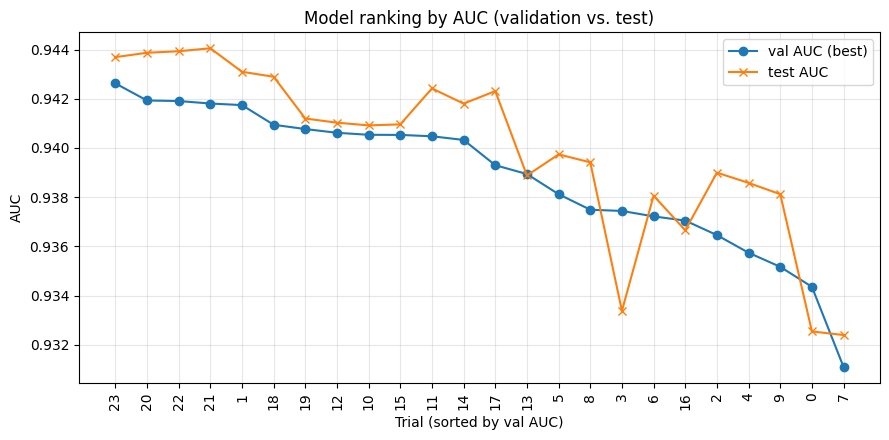

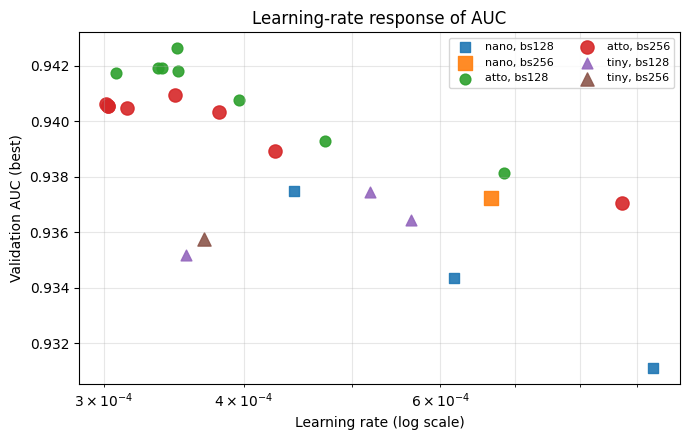

/tmp/ipykernel_178307/2277265135.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showmeans=True)


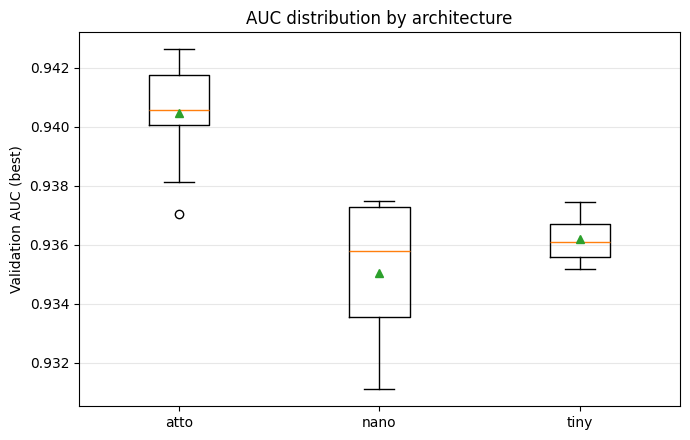

In [21]:
# === Assumes you already built `df` as in your notebook ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re

# ---------- prep ----------
dd = df.copy()

# 통합 아키텍처 라벨
dd["arch"] = dd["arch_dir"].fillna(dd.get("arch_json"))

# 수치형 캐스팅 & 결측 제거
for col in ["lr", "batch", "val_auc_best", "test_auc"]:
    dd[col] = pd.to_numeric(dd[col], errors="coerce")

dd = dd.dropna(subset=["val_auc_best"])  # 핵심 지표 없는 행 제거

# ---------- 1) AUC 랭킹 곡선 (val vs test) ----------
ranked = dd.sort_values("val_auc_best", ascending=False).reset_index(drop=True)

plt.figure(figsize=(9, 4.5))
plt.plot(ranked["val_auc_best"].values, marker="o", label="val AUC (best)")
plt.plot(ranked["test_auc"].values, marker="x", label="test AUC")
plt.xticks(range(len(ranked)), ranked["trial"].astype(int).astype(str), rotation=90)
plt.xlabel("Trial (sorted by val AUC)")
plt.ylabel("AUC")
plt.title("Model ranking by AUC (validation vs. test)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 2) Hyperparameter sensitivity: LR vs val AUC ----------
# 마커: 아키텍처, 크기: 배치
marker_map = {"atto": "o", "nano": "s", "tiny": "^"}
size_map   = {128: 60, 256: 90}

plt.figure(figsize=(7, 4.5))
for arch in dd["arch"].dropna().unique():
    for b in sorted(dd["batch"].dropna().unique()):
        m = (dd["arch"] == arch) & (dd["batch"] == b)
        if m.any():
            plt.scatter(
                dd.loc[m, "lr"],
                dd.loc[m, "val_auc_best"],
                marker=marker_map.get(arch, "o"),
                s=size_map.get(int(b), 60),
                label=f"{arch}, bs{int(b)}",
                alpha=0.9,
            )
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation AUC (best)")
plt.title("Learning-rate response of AUC")
plt.grid(True, which="both", alpha=0.3)

# 중복 라벨 제거한 범례
handles, labels = plt.gca().get_legend_handles_labels()
seen, H, L = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen:
        H.append(h); L.append(l); seen.add(l)
plt.legend(H, L, fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# ---------- 3) Architecture-wise AUC distribution (boxplot) ----------
groups = []
labels = []
for arch, g in dd.groupby("arch", dropna=True):
    if len(g):
        groups.append(g["val_auc_best"].dropna().values)
        labels.append(str(arch))

plt.figure(figsize=(7, 4.5))
plt.boxplot(groups, labels=labels, showmeans=True)
plt.ylabel("Validation AUC (best)")
plt.title("AUC distribution by architecture")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


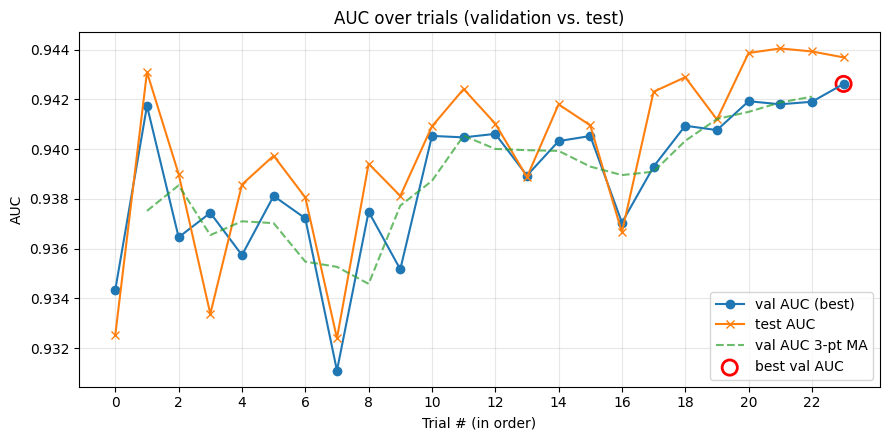

In [22]:
# ---------- 1) AUC 추이곡선 (x축=trial 번호 순서) ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dd = df.copy()
dd["trial"] = pd.to_numeric(dd["trial"], errors="coerce")

seq = (
    dd.sort_values("trial")
      .dropna(subset=["trial", "val_auc_best"])  # 핵심 지표 없는 행 제거
)

plt.figure(figsize=(9, 4.5))
plt.plot(seq["trial"], seq["val_auc_best"], marker="o", label="val AUC (best)")
plt.plot(seq["trial"], seq["test_auc"], marker="x", label="test AUC")

# (선택) 이동평균선으로 추세 가독성 향상
w = 3  # 창 크기
ma = seq["val_auc_best"].rolling(w, center=True).mean()
plt.plot(seq["trial"], ma, linestyle="--", alpha=0.7, label=f"val AUC {w}-pt MA")

# (선택) 최고 val AUC 위치 강조
ib = seq["val_auc_best"].idxmax()
plt.scatter([seq.loc[ib, "trial"]], [seq.loc[ib, "val_auc_best"]],
            s=120, facecolors="none", edgecolors="red", linewidths=2,
            label="best val AUC")

# 축/라벨
step = max(1, int(len(seq) / 12))  # tick 과밀 방지
plt.xticks(seq["trial"][::step])
plt.xlabel("Trial # (in order)")
plt.ylabel("AUC")
plt.title("AUC over trials (validation vs. test)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
